In [1]:
%load_ext autoreload
%autoreload 2

# Experiments on Toy Data

In [2]:
from aggregation import experiment
import numpy as np

mses, cates = experiment(4, n=500, random_state=3)

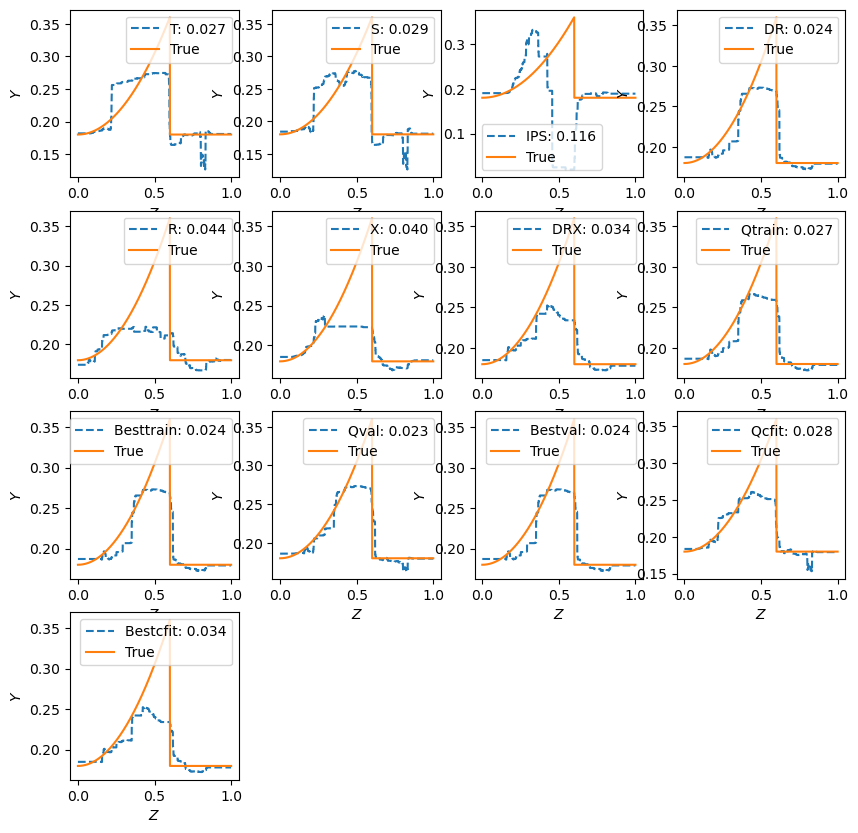

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(4, 4, it + 1)
    plt.plot(cates['Ztest'], cates[name], '--', label=f'{name}: {np.sqrt(mse):.3f}')
    plt.plot(cates['Ztest'], cates['True'], '-', label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [ ]:
from aggregation import experiment
import numpy as np
import joblib
from joblib import Parallel, delayed 

all_results = {}
for n in [500, 1000, 10000]:
    for dgp in np.arange(1, 7):
        all_results[(n, dgp)] = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(dgp, n=n,
                                                                              random_state=it)
                                                          for it in range(100))
        joblib.dump(all_results, 'all_results.jbl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 17.0min remaining:   53.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 405.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 19.7min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 16.8min remaining:   53.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed: 17.0min remaining:   53.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Paral

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

all_results = joblib.load('all_results.jbl')
for n in [500, 1000, 10000]:
    for dgp in np.arange(1, 7):
        results = all_results[(n, dgp)]
        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg = {}
        rmses_all = {}
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results]))
            # clip top 1% failure modes
            q1 = np.percentile(rmses, 99)
            rmses = rmses[(rmses<q1)]
            rmses_all[name] = rmses
            rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                               'stderr': np.std(rmses) / np.sqrt(len(results)),
                               'median': np.median(rmses)}

        agg_means = pd.DataFrame(rmses_agg).T['mean'].values
        min_rmse = np.min(agg_means)
        min_ind = np.argmin(agg_means)
        min_name = names[min_ind]
        min_rmse_std = rmses_agg[min_name]['stderr']
        print(min_rmse, min_name, min_rmse_std)
        
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        rmses_all['oracle'] = oracle
        rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                               'stderr': np.std(oracle) / np.sqrt(len(results)),
                               'median': np.median(oracle)}

        plt.show()
        it = 0
        for name, agg in rmses_agg.items():
            mean = agg['mean']
            if mean >= min_rmse + 20*min_rmse_std:
                continue
            plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                           showextrema=True, quantiles=[.1, .9])
            plt.scatter(name, mean)
            it += 1
        plt.title(f'DGP: {dgp} (n={n})')
        plt.xlabel('Method')
        plt.ylabel('RMSE')
        plt.xlim([-1, it])
        plt.show()
        display(pd.DataFrame(rmses_agg).T)

# Experiments on Semi-Synthetic Data

In [ ]:
data = 'welfare' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}

## For semi-synthetic data generation
semi_synth = True # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [ ]:
mses, cates = experiment(data,
                         semi_synth=semi_synth,
                         simple_synth=simple_synth,
                         max_depth=max_depth,
                         scale=scale,
                         true_f=simple_true_cef,
                         random_state=1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(4, 4, it + 1)
    plt.scatter(cates['Ztest'][:, 1], cates[name], label=f'{name}: {np.sqrt(mse):.4f}')
    plt.scatter(cates['Ztest'][:, 1], cates['True'],  label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [ ]:
results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(data,
                                                             semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             max_depth=max_depth,
                                                             scale=scale,
                                                             true_f=simple_true_cef,
                                                             random_state=it)
                                                  for it in range(100))

In [ ]:
mses, _ = results[0]
names = list(mses.keys())
rmses_agg = {}
rmses_all = {}
for name in names:
    rmses = np.sqrt(np.array([r[0][name] for r in results]))
    # clip top 1% failure modes
    q1 = np.percentile(rmses, 99)
    rmses = rmses[(rmses<q1)]
    rmses_all[name] = rmses
    rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                       'stderr': np.std(rmses) / np.sqrt(len(results)),
                       'median': np.median(rmses)}

agg_means = pd.DataFrame(rmses_agg).T['mean'].values
min_rmse = np.min(agg_means)
min_ind = np.argmin(agg_means)
min_name = names[min_ind]
min_rmse_std = rmses_agg[min_name]['stderr']
print(min_rmse, min_name, min_rmse_std)

oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                          if ((not name.startswith('Q')) and (not name.startswith('Best'))
                              and (not name.startswith('Uni')))]),
                axis=0)
rmses_all['oracle'] = oracle
rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                       'stderr': np.std(oracle) / np.sqrt(len(results)),
                       'median': np.median(oracle)}

plt.show()
it = 0
for name, agg in rmses_agg.items():
    mean = agg['mean']
    if mean >= min_rmse + 20*min_rmse_std:
        continue
    plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                   showextrema=True, quantiles=[.1, .9])
    plt.scatter(name, mean)
    it += 1
plt.title(f'DGP: {dgp} (n={n})')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xlim([-1, it])
plt.show()
display(pd.DataFrame(rmses_agg).T)